## Learning PySpark
### Chapter 4: DataFrames
This notebook contains sample code from Chapter 4 of [Learning PySpark]() focusing on PySpark and DataFrames.

In [11]:
%load_ext sparksql_magic

The sparksql_magic extension is already loaded. To reload it, use:
  %reload_ext sparksql_magic


In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = SparkSession \
    .builder \
    .appName("LearningPyspark") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .getOrCreate()

sc = spark.sparkContext

### Generate your own DataFrame
Instead of accessing the file system, let's create a DataFrame by generating the data.  In this case, we'll first create the `stringRDD` RDD and then convert it into a DataFrame when we're reading `stringJSONRDD` using `spark.read.json`.

In [3]:
# Generate our own JSON data 
#   This way we don't have to access the file system yet.
stringJSONRDD = sc.parallelize((""" 
  { "id": "123",
    "name": "Katie",
    "age": 19,
    "eyeColor": "brown"
  }""",
   """{
    "id": "234",
    "name": "Michael",
    "age": 22,
    "eyeColor": "green"
  }""", 
  """{
    "id": "345",
    "name": "Simone",
    "age": 23,
    "eyeColor": "blue"
  }""")
)

In [4]:
# Create DataFrame
swimmersJSON = spark.read.json(stringJSONRDD)

In [5]:
# Create temporary table
swimmersJSON.createOrReplaceTempView("swimmersJSON")

In [6]:
# DataFrame API
swimmersJSON.show()

+---+--------+---+-------+
|age|eyeColor| id|   name|
+---+--------+---+-------+
| 19|   brown|123|  Katie|
| 22|   green|234|Michael|
| 23|    blue|345| Simone|
+---+--------+---+-------+



In [7]:
# SQL Query
spark.sql("select * from swimmersJSON").collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

In [10]:
%%sparksql 
-- Query the data
select * from swimmersJSON

age,eyeColor,id,name
19,brown,123,Katie
22,green,234,Michael
23,blue,345,Simone


#### Inferring the Schema Using Reflection
Note that Apache Spark is inferring the schema using reflection; i.e. it automaticlaly determines the schema of the data based on reviewing the JSON data.

In [13]:
# Print the schema
swimmersJSON.printSchema()

root
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)



Notice that Spark was able to determine infer the schema (when reviewing the schema using `.printSchema`).

But what if we want to programmatically specify the schema?

#### Programmatically Specifying the Schema
In this case, let's specify the schema for a `CSV` text file.

In [14]:
from pyspark.sql.types import *

# Generate our own CSV data 
#   This way we don't have to access the file system yet.
stringCSVRDD = sc.parallelize([(123, 'Katie', 19, 'brown'), (234, 'Michael', 22, 'green'), (345, 'Simone', 23, 'blue')])

# The schema is encoded in a string, using StructType we define the schema using various pyspark.sql.types
schemaString = "id name age eyeColor"
schema = StructType([
    StructField("id", LongType(), True),    
    StructField("name", StringType(), True),
    StructField("age", LongType(), True),
    StructField("eyeColor", StringType(), True)
])

# Apply the schema to the RDD and Create DataFrame
swimmers = spark.createDataFrame(stringCSVRDD, schema)

# Creates a temporary view using the DataFrame
swimmers.createOrReplaceTempView("swimmers")

In [15]:
# Print the schema
#   Notice that we have redefined id as Long (instead of String)
swimmers.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)



%sql 
-- Query the data
select * from swimmers

In [16]:
spark.sql("select * from swimmers").show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|123|  Katie| 19|   brown|
|234|Michael| 22|   green|
|345| Simone| 23|    blue|
+---+-------+---+--------+



As you can see from above, we can programmatically apply the `schema` instead of allowing the Spark engine to infer the schema via reflection.

Additional Resources include:
* [PySpark API Reference](https://spark.apache.org/docs/2.0.0/api/python/pyspark.sql.html)
* [Spark SQL, DataFrames, and Datasets Guide](https://spark.apache.org/docs/latest/sql-programming-guide.html#programmatically-specifying-the-schema): This is in reference to Programmatically Specifying the Schema using a `CSV` file.

####|| SparkSession

Notice that we're no longer using `sqlContext.read...` but instead `spark.read...`.  This is because as part of Spark 2.0, `HiveContext`, `SQLContext`, `StreamingContext`, `SparkContext` have been merged together into the Spark Session `spark`.
* Entry point for reading data
* Working with metadata
* Configuration
* Cluster resource management

For more information, please refer to [How to use SparkSession in Apache Spark 2.0](http://bit.ly/2br0Fr1) (http://bit.ly/2br0Fr1).

### Querying with SQL
With DataFrames, you can start writing your queries using `Spark SQL` - a SQL dialect that is compatible with the Hive Query Language (or HiveQL).

In [17]:
# Execute SQL Query and return the data
spark.sql("select * from swimmers").show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|123|  Katie| 19|   brown|
|234|Michael| 22|   green|
|345| Simone| 23|    blue|
+---+-------+---+--------+



Let's get the row count:

In [18]:
# Get count of rows in SQL
spark.sql("select count(1) from swimmers").show()

+--------+
|count(1)|
+--------+
|       3|
+--------+



Note, you can make use of `%sql` within the notebook cells of a Databricks notebook.

In [22]:
%%sparksql
-- Query all data
select * from swimmers

id,name,age,eyeColor
123,Katie,19,brown
234,Michael,22,green
345,Simone,23,blue


In [23]:
# Query id and age for swimmers with age = 22 via DataFrame API
swimmers.select("id", "age").filter("age = 22").show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [24]:
# Query id and age for swimmers with age = 22 via DataFrame API in another way
swimmers.select(swimmers.id, swimmers.age).filter(swimmers.age == 22).show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [25]:
# Query id and age for swimmers with age = 22 in SQL
spark.sql("select id, age from swimmers where age = 22").show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [27]:
%%sparksql
-- Query id and age for swimmers with age = 22
select id, age from swimmers where age = 22

id,age
234,22


In [28]:
# Query name and eye color for swimmers with eye color starting with the letter 'b'
spark.sql("select name, eyeColor from swimmers where eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



In [29]:
%%sparksql
-- Query name and eye color for swimmers with eye color starting with the letter 'b'
select name, eyeColor from swimmers where eyeColor like 'b%'

name,eyeColor
Katie,brown
Simone,blue


### Querying with the DataFrame API
With DataFrames, you can start writing your queries using the DataFrame API

In [30]:
# Show the values 
swimmers.show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|123|  Katie| 19|   brown|
|234|Michael| 22|   green|
|345| Simone| 23|    blue|
+---+-------+---+--------+



In [31]:
# Using Databricks `display` command to view the data easier
#display(swimmers)
swimmers

id,name,age,eyeColor
123,Katie,19,brown
234,Michael,22,green
345,Simone,23,blue


In [32]:
# Get count of rows
swimmers.count()

3

In [33]:
# Get the id, age where age = 22
swimmers.select("id", "age").filter("age = 22").show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [34]:
# Get the name, eyeColor where eyeColor like 'b%'
swimmers.select("name", "eyeColor").filter("eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



## On-Time Flight Performance
Query flight departure delays by State and City by joining the departure delay and join to the airport codes (to identify state and city).

### DataFrame Queries
Let's run a flight performance using DataFrames; let's first build the DataFrames from the source datasets.

In [35]:
# Set File Paths
flightPerfFilePath = "flight-data/departuredelays.csv"
airportsFilePath = "flight-data/airport-codes-na.txt"

# Obtain Airports dataset
airports = spark.read.csv(airportsFilePath, header='true', inferSchema='true', sep='\t')
airports.createOrReplaceTempView("airports")

# Obtain Departure Delays dataset
flightPerf = spark.read.csv(flightPerfFilePath, header='true')
flightPerf.createOrReplaceTempView("FlightPerformance")

# Cache the Departure Delays dataset 
flightPerf.cache()

date,delay,distance,origin,destination
01011245,6,602,ABE,ATL
01020600,-8,369,ABE,DTW
01021245,-2,602,ABE,ATL
01020605,-4,602,ABE,ATL
01031245,-4,602,ABE,ATL
01030605,0,602,ABE,ATL
01041243,10,602,ABE,ATL
01040605,28,602,ABE,ATL
01051245,88,602,ABE,ATL
01050605,9,602,ABE,ATL


In [36]:
# Query Sum of Flight Delays by City and Origin Code (for Washington State)
spark.sql("select a.City, f.origin, sum(f.delay) as Delays from FlightPerformance f join airports a on a.IATA = f.origin where a.State = 'WA' group by a.City, f.origin order by sum(f.delay) desc").show()

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
|  Pasco|   PSC|   949.0|
+-------+------+--------+



<Axes: xlabel='city'>

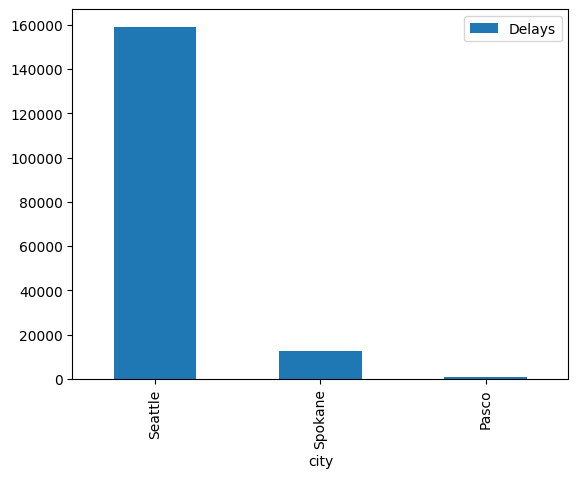

In [58]:
import pyspark.sql.functions as F

cond = (F.col("f.origin") == F.col("a.IATA"))

df = (flightPerf.alias("f").join(airports.alias("a"), on=cond , how="left")
 .select(F.col("a.city"), F.col("f.origin"), F.col("delay")).where(F.col("a.State") == "WA")
 .groupBy(F.col("a.city"), F.col("f.origin"))
 .agg(F.sum("f.delay").alias("Delays"))
 .orderBy(F.col("Delays").desc())
).drop(F.col("f.delay"))

df.toPandas().plot.bar(x="city", y="Delays")

In [38]:
%%sparksql
-- Query Sum of Flight Delays by City and Origin Code (for Washington State)
select a.City, f.origin, sum(f.delay) as Delays
  from FlightPerformance f
    join airports a
      on a.IATA = f.origin
 where a.State = 'WA'
 group by a.City, f.origin
 order by sum(f.delay) desc
 

City,origin,Delays
Seattle,SEA,159086.0
Spokane,GEG,12404.0
Pasco,PSC,949.0


In [39]:
# Query Sum of Flight Delays by State (for the US)
spark.sql("select a.State, sum(f.delay) as Delays from FlightPerformance f join airports a on a.IATA = f.origin where a.Country = 'USA' group by a.State ").show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
| null| 397237.0|
|   WY|  15365.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   MT|  19271.0|
|   NC| 394256.0|
|   VT|  14755.0|
|   MD| 362845.0|
|   IL|1630792.0|
|   ME|  15214.0|
+-----+---------+
only showing top 20 rows



In [40]:
%%sparksql
-- Query Sum of Flight Delays by State (for the US)
select a.State, sum(f.delay) as Delays
  from FlightPerformance f
    join airports a
      on a.IATA = f.origin
 where a.Country = 'USA'
 group by a.State 

only showing top 20 row(s)


State,Delays
SC,80666.0
LA,199136.0
MN,256811.0
NJ,452791.0
OR,109333.0
VA,98016.0
null,397237.0
WY,15365.0
MI,366486.0
NV,474208.0


In [41]:
%%sparksql
-- Query Sum of Flight Delays by State (for the US)
select a.State, sum(f.delay) as Delays
  from FlightPerformance f
    join airports a
      on a.IATA = f.origin
 where a.Country = 'USA'
 group by a.State 

only showing top 20 row(s)


State,Delays
SC,80666.0
LA,199136.0
MN,256811.0
NJ,452791.0
OR,109333.0
VA,98016.0
null,397237.0
WY,15365.0
MI,366486.0
NV,474208.0


For more information, please refer to:
* [Spark SQL, DataFrames and Datasets Guide](http://spark.apache.org/docs/latest/sql-programming-guide.html#sql)
* [PySpark SQL Module: DataFrame](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame)
* [PySpark SQL Functions Module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions)